# Preperation

Eric Houtman, Rick Lattin, Kellen Long

We plan to use accuracy as the metric for our model performance. This metric is appropriate for our data due to the fact that the application of our models is for the classification of animals. The nature of classification makes it so that the percentage of the testing data that is guessed correctly by the classifier is what is most valuable when judging the model, as the model has no continuous range of answers to try and estimate from. Hence we use accuracy. Furthermore, the fact that the subjects of our classifications are living animals, it leaves room for the classification task to be applied to actual living things, making the gravity of the task of predicting the correct class for each individual animal much more serious.

In [148]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible
tf.config.list_physical_devices('GPU')

#load in half of the dogs and cats images
cat_folder = '../lab 6/train/cat/'
dog_folder = '../lab 6/train/dog/'
wild_folder = '../lab 6/train/wild/'

In [149]:
#grab 100 images from each folder
cat_files = os.listdir(cat_folder)[:100]
dog_files = os.listdir(dog_folder)[:100]
wild_files = os.listdir(wild_folder)[:100]


#load in the images
cat_images = [tf.keras.preprocessing.image.load_img(cat_folder + cat_file, target_size=(224, 224)) for cat_file in cat_files]
dog_images = [tf.keras.preprocessing.image.load_img(dog_folder + dog_file, target_size=(224, 224)) for dog_file in dog_files]
wild_images = [tf.keras.preprocessing.image.load_img(wild_folder + wild_file, target_size=(224, 224)) for wild_file in wild_files]

#normalize the images 
cat_images = [tf.keras.preprocessing.image.img_to_array(cat_image)/255.0 for cat_image in cat_images]
dog_images = [tf.keras.preprocessing.image.img_to_array(dog_image)/255.0 for dog_image in dog_images]
wild_images = [tf.keras.preprocessing.image.img_to_array(wild_image)/255.0 for wild_image in wild_images]

#combine the images into a single list
images = cat_images + dog_images + wild_images

labels = [0 for _ in range(100)] + [1 for _ in range(100)] + [2 for _ in range(100)]

#convert the list to a numpy array
images = np.array(images)

#reshape the array
images = images.reshape(images.shape[0], 224, 224, 3)

#convert the labels to a numpy array
labels = np.array(labels)

X = images
y = labels

#import shuffle split   
from sklearn.model_selection import ShuffleSplit

#split the data into training and testing sets
rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=0)
train_index, test_index = next(rs.split(X))

X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

For this dataset, we used ShuffleSplit to partition the data. We felt this was a sufficient strategy due to the fact that the class ratioes of the testing data (dog, cat, wild) are already at about an even split, so stratifying it is not necessary and we are able to save some computational power by implimenting shuffle split over a method that would have statified the data. We still maintain an 80/20 split in the data.

In [150]:
tf.config.list_physical_devices('GPU')

[]

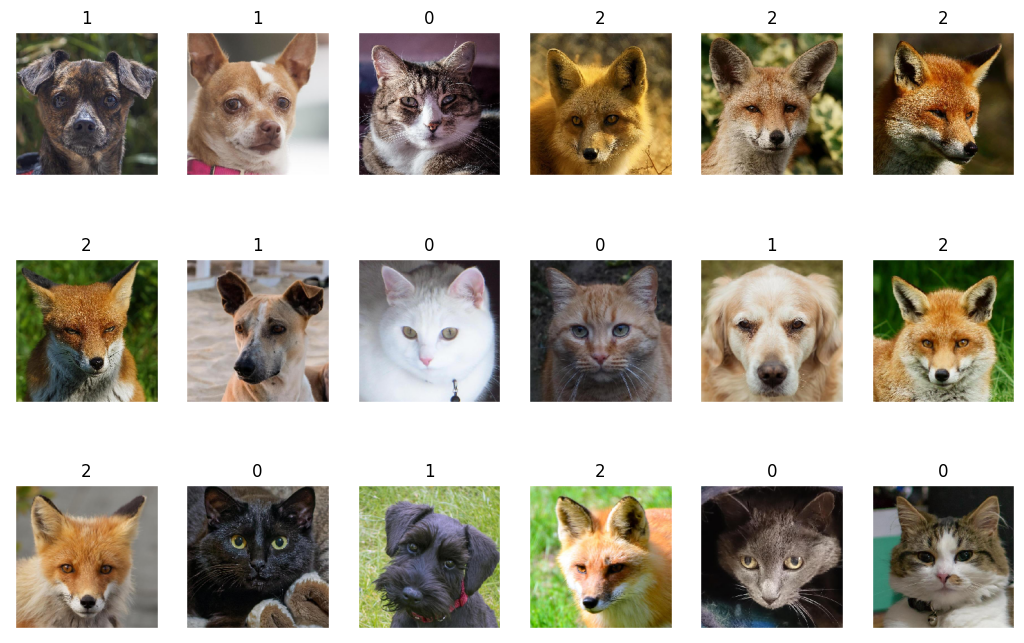

In [151]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

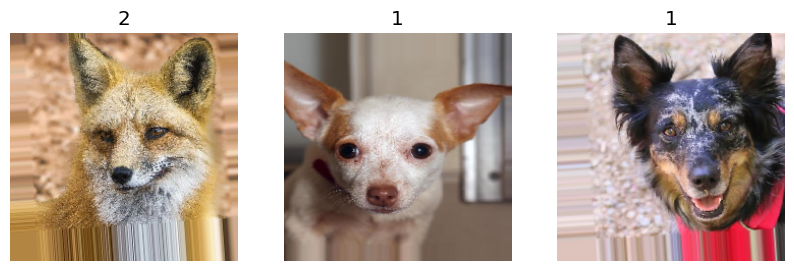

In [152]:
#import the keras imagedatagenerator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True) # horizontal flip

# iterator
aug_iter = datagen.flow(X_train, y_train, batch_size=64)

# generate samples and plot
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

for i in range(3):
    image, label = aug_iter.next()
    ax[i].imshow(image[0])
    ax[i].set_title(label[0])
    ax[i].axis('off')
    
#use the keras imagedatagenerator to bolster the training data
datagen.fit(X_train)




In [153]:
import tensorflow.keras as keras

keras.__version__

'2.12.0'

# Modeling

First, we create a basic Multi Layer Processor as a baseline to attempt to classify the animal images.

In [154]:
%%time

NUM_CLASSES = 3

# since this is not binary, we should go ahead and one-hot encode the inputs
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: total: 1min 8s
Wall time: 35.9 s


We then create a Convolutional Neural Network to attempt to classify the animal images.

In [155]:
%%time

cnn = Sequential()

num_filt_layers = [8,16,32]
for num_filters in num_filt_layers:
    cnn.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn.add( Activation('relu'))
    cnn.add( MaxPooling2D(pool_size=(2, 2)) )
    
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )
 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              #use metrics accuracy and F1-score
              metrics=['accuracy'])

#use the history object that is returned from model.fit to make graphs of the model performance
history = cnn.fit(X_train, y_train_ohe,
                    batch_size=32, epochs=150,
                    shuffle=True, verbose=0,
                    validation_data=(X_test, y_test_ohe))


cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 activation_12 (Activation)  (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 activation_13 (Activation)  (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

In [156]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        #show the f1 score as well
        f1_cnn = mt.f1_score(y_test,yhat_cnn,average=None)

        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

2/2 [==============================] - 0s 15ms/step


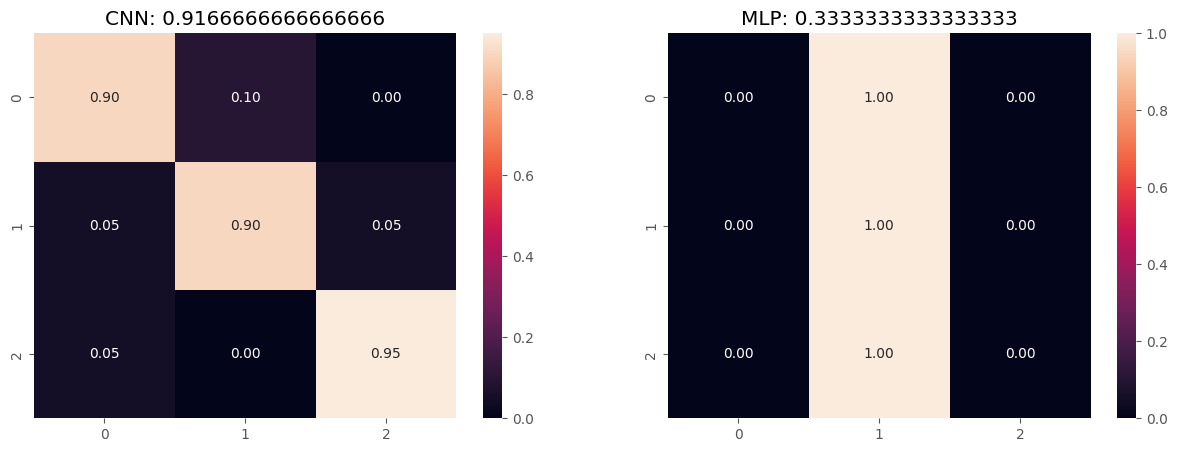

In [157]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

These confusion matrices display how the CNN model performed with an accuracy of about 91.7% where the MLP model only performed with an accuracy of about 33%. As is illustrated by the vertical bar (the bar that is colored lighter on the MPL confusion matrix), the MLP is essentially only classifying images into one class, causing only the images in the one class to be classified correctly. This expresses how poorly MLP models perform with respect to image data, a reality that becomes blatantly more clear when compared to the basic CNN model which performs with an over 91% accuracy rate. This can be seen through the diagonal light colored line on the CNN confusion matrix, displaying 90-95% accuracies for each class of the data.

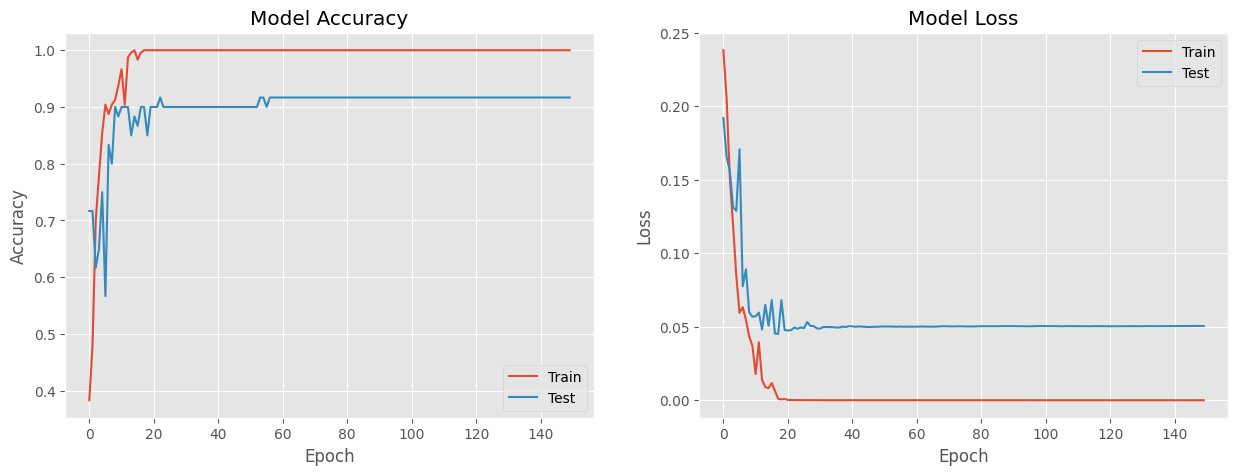

In [158]:
#plot the model's accuracy and loss for train and test set
def plot_history(history):
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    
    plt.show()

plot_history(history)

As is displayed by both of these graphs, the accuracy of the CNN model steadily increases and the loss of the CNN model steadily decreases. Both metrics plateau around 20 epochs. Overfitting does not seem to be a prominent issue for either graph as the testing line does not appear to degenerate past the values at around 60 epochs for accuracy and the minimum values for loss.

We then create another variation of a Convolutional Nueral Network (CNN2) to attempt to classify the animal images.

2/2 [==============================] - 0s 9ms/step
CPU times: total: 6min 27s
Wall time: 5min 50s


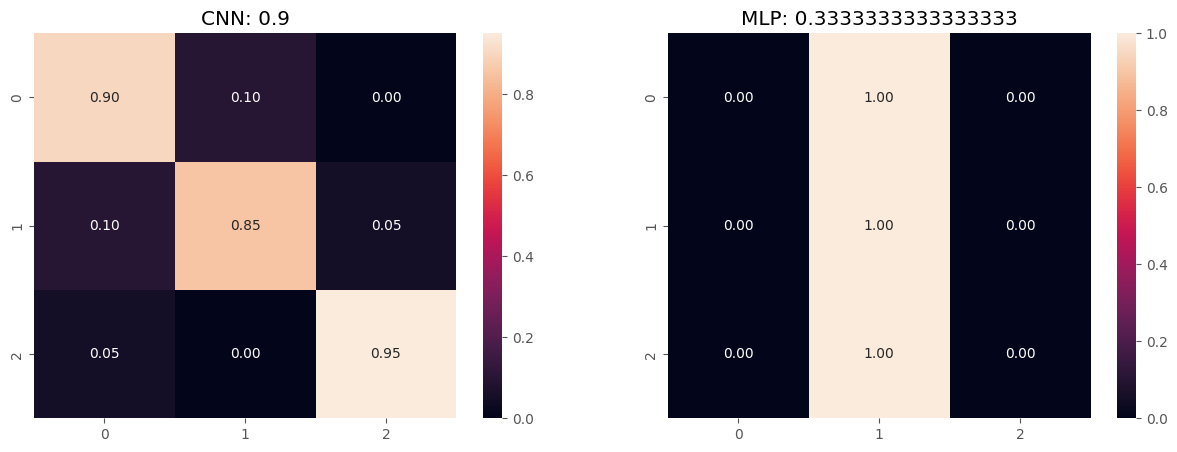

In [159]:
%%time

cnn2 = Sequential()

#change up the number of filters
num_filt_layers = [8,16,32,64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn2.add( Activation('relu'))
    cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
    
#use different architecture
cnn2.add( Flatten() )
cnn2.add( Dense(30) )
cnn2.add( Activation('relu') )
cnn2.add( Dense(NUM_CLASSES) )
cnn2.add( Activation('softmax') )
 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              #use metrics accuracy and F1-score
              metrics=['accuracy'])

history = cnn2.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150,
        shuffle=True, verbose=0,
        validation_data=(X_test, y_test_ohe))

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

These confusion matrices display how the CNN2 model performed with an accuracy of about 90%, where the MLP model only performed with an accuracy of about 33%. Much like the previous graphs, the CNN2 model performs much better than the MLP model, seen by the vertical lighly colored bar on the MLP matrix and the diagonal lighlty colored bar on the CNN2. CNN2 performed slightly worse than the CNN model, but that can be attributed to nothing more than basic variance.

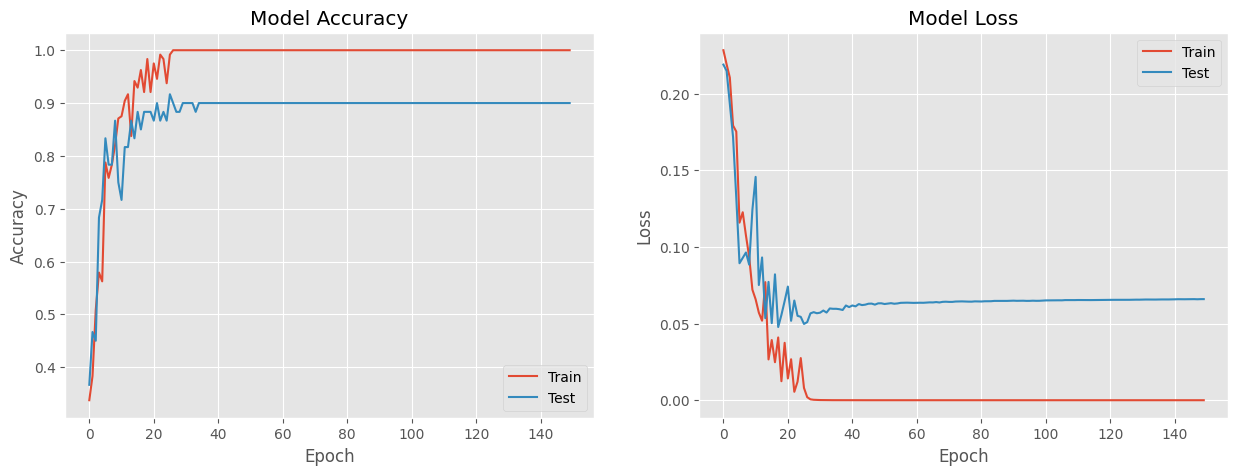

In [160]:
plot_history(history)

As is displayed by both of these graphs, the accuracy of the CNN2 model steadily increases and the loss of the CNN2 model steadily decreases. Like the previous models, both metrics plateau around 20 epochs. Overfitting does not seem to be a prominent issue for either graph as the testing line does not appear to degenerate past the values at around 40 epochs for accuracy and the minimum values for loss.

We then create another variation of a Convolutional Nueral Network (CNN3) to attempt to classify the animal images.

2/2 [==============================] - 0s 7ms/step
CPU times: total: 7min 55s
Wall time: 5min 7s


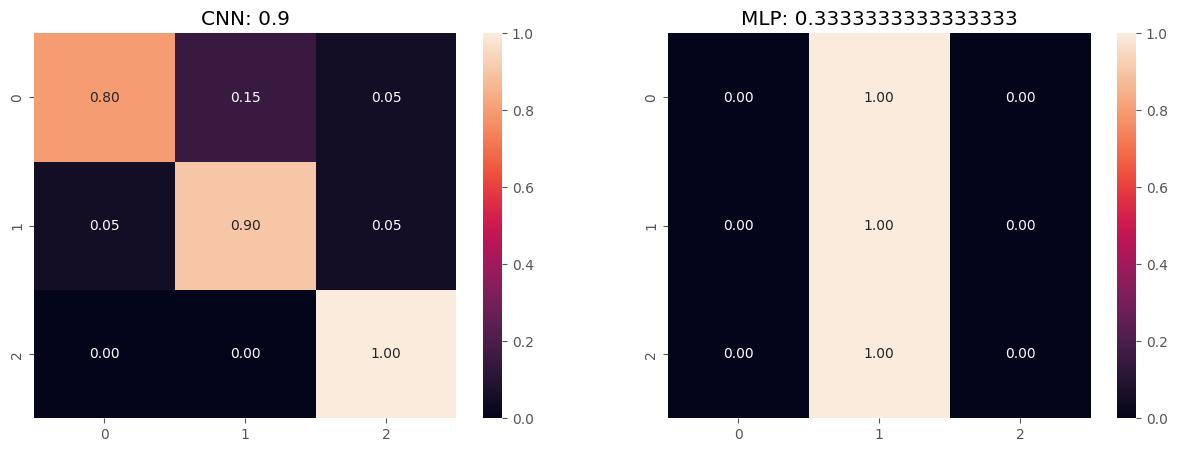

In [161]:
%%time

cnn3 = Sequential()

#use different number of filters
num_filt_layers = [ 8,16,32,64,128]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )
 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              #use metrics accuracy and F1-score
              metrics=['accuracy'])

history = cnn3.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0,
        validation_data=(X_test, y_test_ohe))


compare_mlp_cnn(cnn3,mlp,X_test,y_test)

These confusion matrices display how the CNN3 model performed with an accuracy of about 90%, where the MLP model only performed with a n accuracy of about 33%. Much like the previous graphs, the CNN3 model performs much better than the MLP model, seen by the vertical lighly colored bar on the MLP matrix and the diagonal lighlty colored bar on the CNN3. CNN3 performed slightly worse than the CNN model, but that can be attributed to nothing more than basic variance.

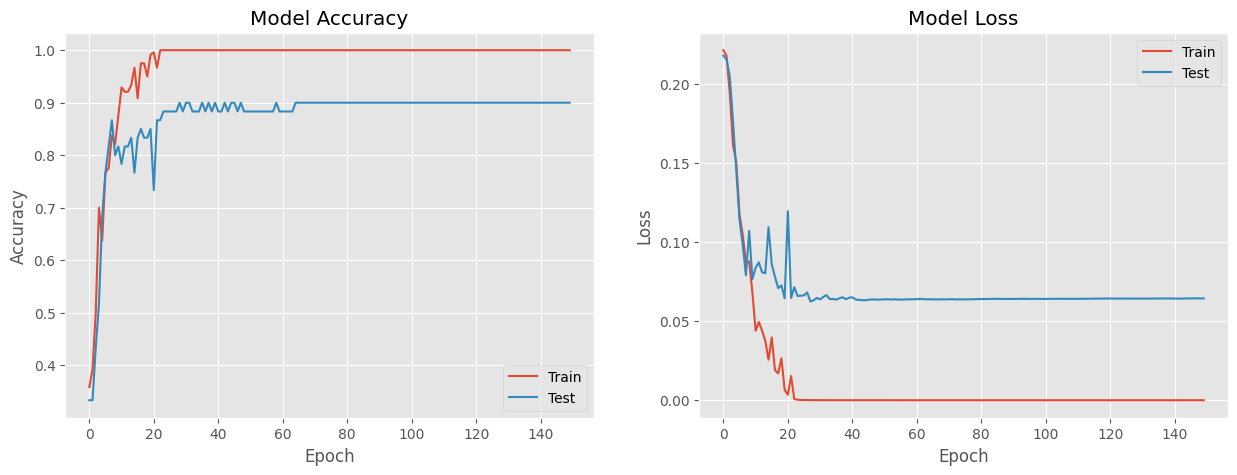

In [162]:
plot_history(history)

As is displayed by both of these graphs, the accuracy of the CNN3 model steadily increases and the loss of the CNN3 model steadily decreases. Like the previous models both metrics plateau around 20 epochs, but the accuracy makes another slight increase at around 60 epochs before plateauing again. Overfitting does not seem to be a prominent issue for either graph as the testing line does not appear to degenerate past the values at around 65 epochs for accuracy and the minimum values for loss.

We then create another variation of a Convolutional Nueral Network (CNN4) to attempt to classify the animal images.

2/2 [==============================] - 0s 4ms/step
CPU times: total: 10min 22s
Wall time: 3min 57s


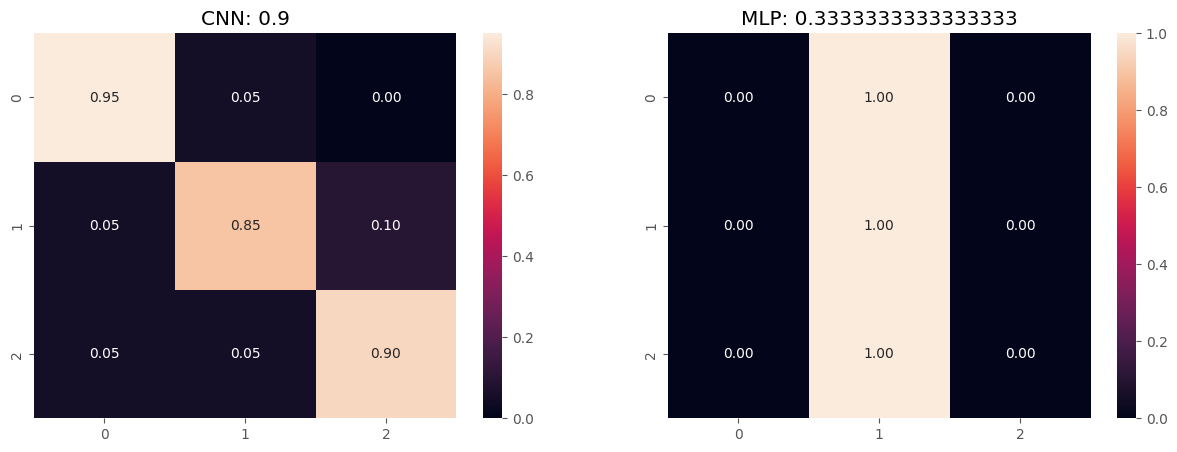

In [163]:
%%time

cnn4 = Sequential()

#change up the number of filters
num_filt_layers = [ 8,16,32,64,128]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)) )
    
#use different architecture
cnn4.add( Flatten() )
cnn4.add( Dense(30) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )
 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              #use metrics accuracy and F1-score
              metrics=['accuracy'])

history = cnn4.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0,
        validation_data=(X_test, y_test_ohe))

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

These confusion matrices display how the CNN4 model performed with an accuracy of about 90%, where the MLP model only performed with a n accuracy of about 33%. Much like the previous graphs, the CNN4 model performs much better than the MLP model, seen by the vertical lighly colored bar on the MLP matrix and the diagonal lighlty colored bar on the CNN4. CNN4 performed slightly worse than the CNN model, but that can be attributed to nothing more than basic variance.

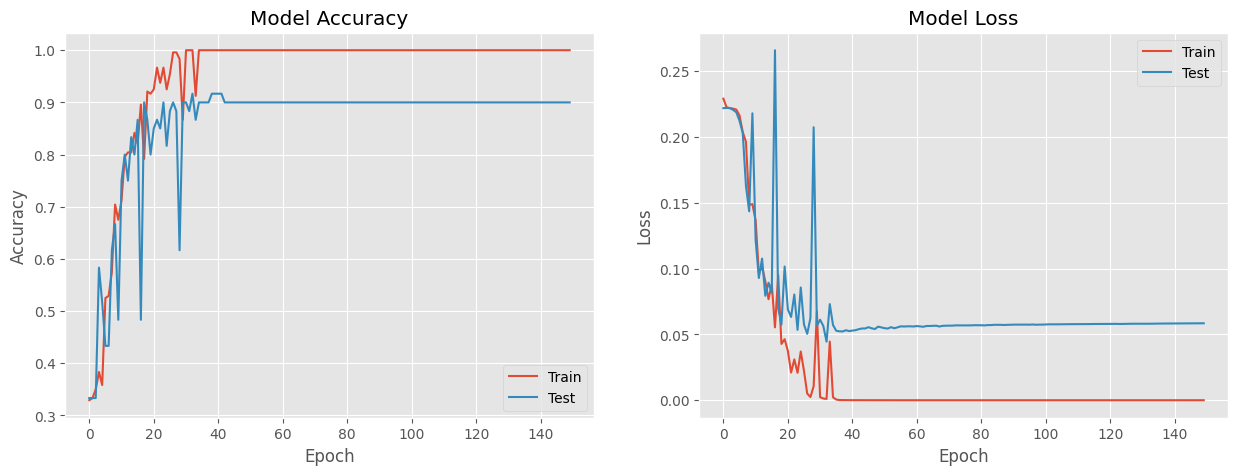

In [164]:
plot_history(history)

As is displayed by both of these graphs the accuracy of the CNN4 model steadily increases and the loss of the CNN4 model steadily decreases. Both metrics plateau around 40 epochs. Overfitting does not seem to be a prominent issue for either graph as the testing line does not appear to degenerate past the values at around 45 epochs for accuracy and the minimum values for loss.

# Exceptional Work (7000 level)

We then create a Convolutional Nueral Network (model) using transfer learning to attempt to classify the animal images.

In [165]:
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions

if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)


x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_no_top.predict(x)
preds.shape


1/1 [==============================] - 0s 358ms/step


(1, 7, 7, 2048)

In [166]:
x_train_up = preprocess_input(X_train)
x_test_up = preprocess_input(X_test)

In [167]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)


2/2 [==============================] - 2s 790ms/step
(240, 7, 7, 2048)
CPU times: total: 22.1 s
Wall time: 8.52 s


In [168]:
from keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from tensorflow.keras.layers import Input
from keras.models import Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_14 (Flatten)        (None, 100352)            0         
                                                                 
 dense_28 (Dense)            (None, 200)               20070600  
                                                                 
 dense_29 (Dense)            (None, 3)                 603       
                                                                 
Total params: 20,071,203
Trainable params: 20,071,203
Non-trainable params: 0
_________________________________________________________________


In [172]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=60,
            batch_size=32,verbose=0,
            validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

history = model.fit(x_train_resnet,y_train_ohe_resnet,epochs=60,
            batch_size=32,verbose=0,
            validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

2/2 [==============================] - 0s 8ms/step


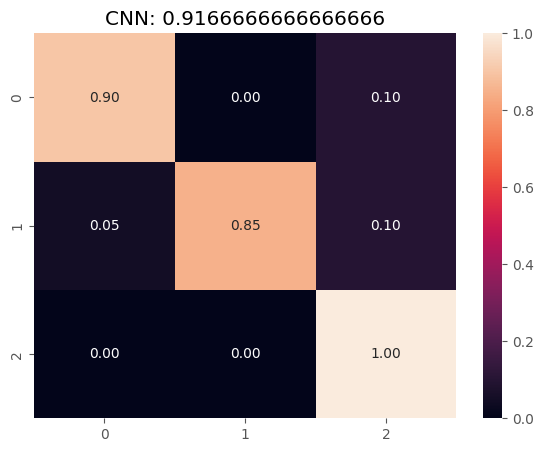

In [173]:
compare_mlp_cnn(model,None,x_test_resnet,y_test)

This confusion matrix displays how the model that impliments transfer learning performed with an accuracy of about 91.7%. This model performed as well as the original CNN model, but the increase in the performance over the other CNNs can be attributed to nothing more than basic variance. Nonetheless, it displays how transfer learning can be used to effectivley tackle classification tasks.

In [174]:
#print the accuracy
score = model.evaluate(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 9ms/step - loss: 0.2158 - accuracy: 0.9167
Test accuracy: 0.9166666865348816
